# 8. Calibration of double-ended measurements

A double-ended calibration is performed where the unknown parameters are estimated using fiber sections that have a reference temperature. The parameters are estimated with a weighted least squares optimization using Stokes and anti-Stokes measurements from all timesteps. Thus Stokes and anti-Stokes measurements with a large signal to noise ratio contribute more towards estimating the optimal parameter set. But an estimate of the noise variance is required.

Double-ended calibration requires a few steps. Please have a look at [1] for more information:
- Read the raw data files loaded from your DTS machine
- Define the reference fiber sections that have a known temperature
- Estimate the variance of the noise in the Stokes and anti-Stokes measurements
- Perform the parameter estimation and compute the temperature along the entire fiber.
- Plot the uncertainty of the estimated temperature

[1]: des Tombe, B., Schilperoort, B., & Bakker, M. (2020). Estimation of Temperature and Associated Uncertainty from Fiber-Optic Raman-Spectrum Distributed Temperature Sensing. Sensors, 20(8), 2235. https://doi.org/10.3390/s20082235

In [1]:
import os
import warnings

from dtscalibration import read_silixa_files
import matplotlib.pyplot as plt

warnings.simplefilter('ignore')  # Hide warnings to avoid clutter in the notebook
%matplotlib inline

# Read the raw data files loaded from your DTS machine
Use `read_silixa_files` for reading files from a Silixa device. The following functions are available for reading files from other devices: `read_sensortran_files`, `read_apsensing_files`, and `read_sensornet_files`. See Notebook 1.

In [2]:
filepath = os.path.join('..', '..', 'tests', 'data', 'double_ended2')

ds_ = read_silixa_files(
    directory=filepath,
    timezone_netcdf='UTC',
    file_ext='*.xml')

6 files were found, each representing a single timestep
6 recorded vars were found: LAF, ST, AST, REV-ST, REV-AST, TMP
Recorded at 1693 points along the cable
The measurement is double ended
Reading the data from disk


Select the part of the fiber that contains relevant measurements using the `sel` command. Slice the time dimension to select the measurements of the relevant times.

In [3]:
ds = ds_.sel(x=slice(0, 100))  # only calibrate parts of the fiber

# Define the reference fiber sections that have a known temperature
As explained in Notebook 3

In [4]:
ds.sections = {
    'probe1Temperature': [slice(7.5, 17.), slice(70., 80.)],  # cold bath
    'probe2Temperature': [slice(24., 34.), slice(85., 95.)],  # warm bath
    }

# Estimate the variance of the noise in the Stokes and anti-Stokes measurements
First calculate the variance in the measured Stokes and anti-Stokes signals, in the forward and backward direction. See Notebook 4 for more information.

The Stokes and anti-Stokes signals should follow a smooth decaying exponential. This function fits a decaying exponential to each reference section for each time step. The variance of the residuals between the measured Stokes and anti-Stokes signals and the fitted signals is used as an estimate of the variance in measured signals. This algorithm assumes that the temperature is the same for the entire section but it may vary over time and differ per section.

In [5]:
st_var, resid = ds.variance_stokes_constant(st_label='st')
ast_var, _ = ds.variance_stokes_constant(st_label='ast')
rst_var, _ = ds.variance_stokes_constant(st_label='rst')
rast_var, _ = ds.variance_stokes_constant(st_label='rast')

The following plot can be used to check if there are no spatial or temporal correlated residuals. If you see horizontal or vertical lines that means that you overestimate the st_var. Common reasons are that the temperature of that section is not constant, e.g. that the reference sections were defined falsely or that the temperature of the water baths were not uniform.

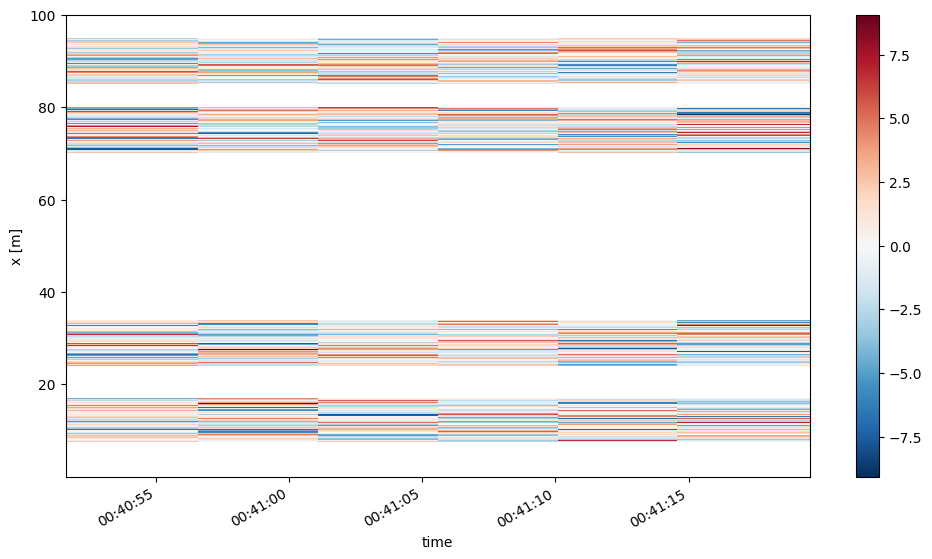

In [6]:
resid.plot(figsize=(12, 6));

# Perform calibration and compute the temperature
We calibrate the measurements with a single method call. Three temperatures are estimated for double-ended setups. The temperature of the forward channel, `tmpf`. The temperature of the backward channel, `tmpb`. And the weigthed average of the two, `tmpw`. The latter is the best estimate with the smallest uncertainty.

In [19]:
ds.calibration_double_ended(
    st_var=st_var,
    ast_var=ast_var,
    rst_var=rst_var,
    rast_var=rast_var,
    mc_sample_size=10000,      # Optional
    mc_conf_ints=[2.5, 97.5]   # Optional
)

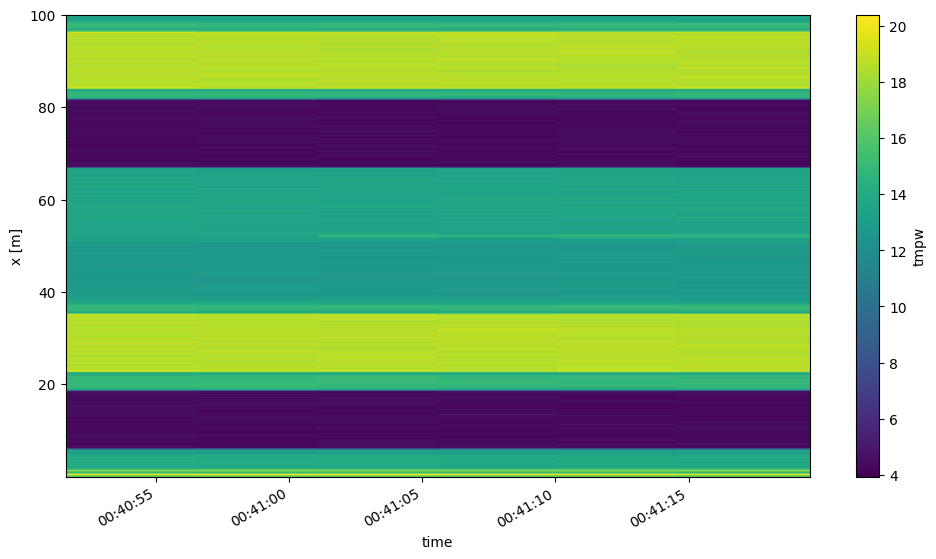

In [14]:
ds.tmpw.plot(figsize=(12, 6));

# Uncertainty of the calibrated temperature
The uncertainty of the calibrated temperature can be computed in two manners:
1. The variance of the calibrated temperature can be approximated using linear error propagation
    - Very fast computation
    - Only the variance is estimated
    - Does not correctly propagate all uncertainty from the calibration
    - Sufficiently accurate approximation for most cases
2. The uncertainty distribution of the calibrated temperature can be approximated using Monte Carlo
    - Slow computation
    - Computes variances and confidence intervals
    - Correctly propagates all uncertainties from the calibration
    - Requires sufficiently large number of samples to be drawn to be correct, hence the slow computation.
    - Only use this method: 1) To check the first method. 2) Specific interest in confidence intervals.

### 1. The variance approximated using linear error propagation
This first method works pretty good and is computed when calling the `ds.calibration_double_ended()` function.

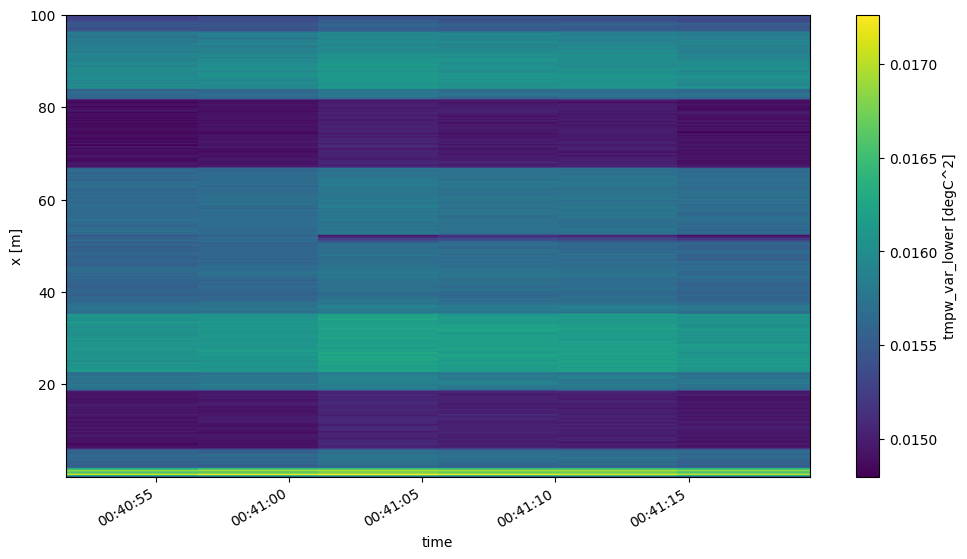

In [15]:
ds.tmpw_var_lower.plot(figsize=(12, 6));

### 2. Uncertainty approximation using Monte Carlo

If `mc_sample_size` keyword argument is passed to the `ds.calibration_double_ended()` function, the uncertainty distribution of the estimated temperature is computed using a Monte Carlo approach. The variance of that distribution is accessed via `tmpw_mc_var`.

The uncertainty comes from the noise in the (anti-) Stokes measurements and from the parameter estimation. Both sources are propagated via Monte Carlo sampling to an uncertainty distribution of the estimated temperature. As weigths are correctly passed to the least squares procedure via the `st_var` arguments, the covariance matrix can be used as an estimator for the uncertainty in the parameters. This matrix holds the covariances between all the parameters. A large parameter set is generated from this matrix as part of the Monte Carlo routine, assuming the parameter space is normally distributed with their mean at the best estimate of the least squares procedure.

The large parameter set is used to calculate a large set of temperatures. By using `percentiles` or `quantile` the 95% confidence interval of the calibrated temperature between 2.5% and 97.5% are calculated. The confidence intervals differ per time step. If you would like to calculate confidence intervals temporal averages or averages of fiber sections see notebook 16.

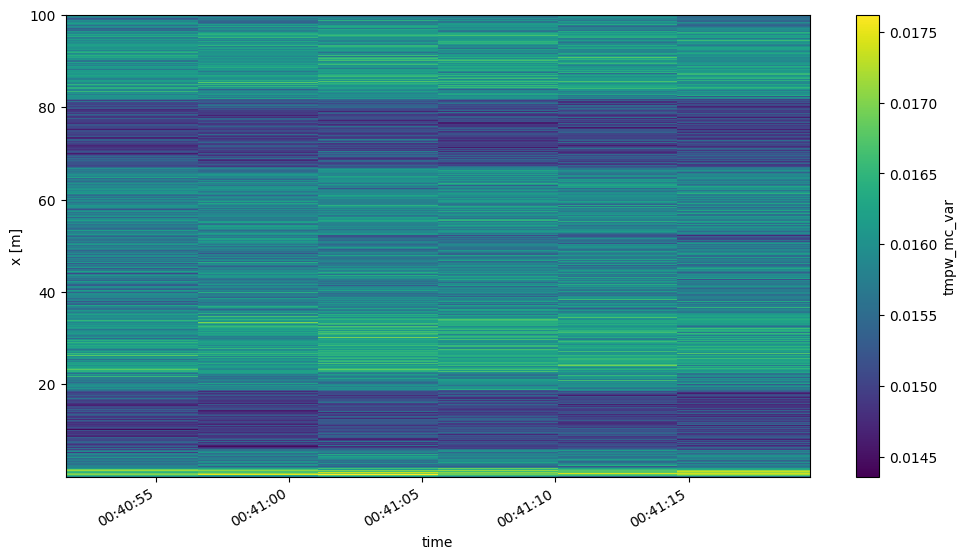

In [16]:
ds.tmpw_mc_var.plot(figsize=(12, 6));

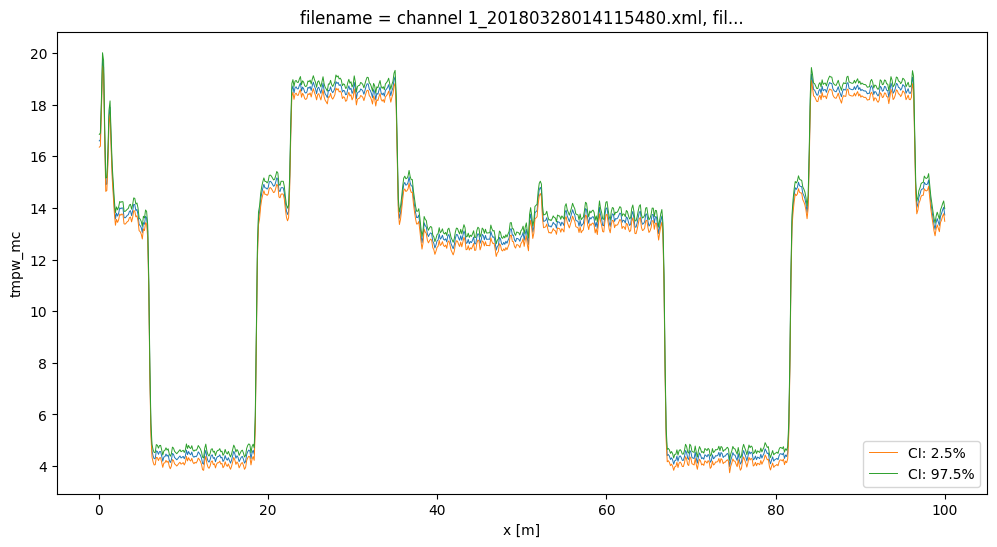

In [17]:
ds1 = ds.isel(time=-1)  # take only the first timestep
ds1.tmpw.plot(linewidth=0.7, figsize=(12, 6))
ds1.tmpw_mc.isel(CI=0).plot(linewidth=0.7, label='CI: 2.5%')
ds1.tmpw_mc.isel(CI=1).plot(linewidth=0.7, label='CI: 97.5%')
plt.legend();

The DataArrays `tmpf_mc` and `tmpb_mc` and the dimension `CI` are added. `MC` stands for monte carlo and the `CI` dimension holds the confidence interval 'coordinates'.

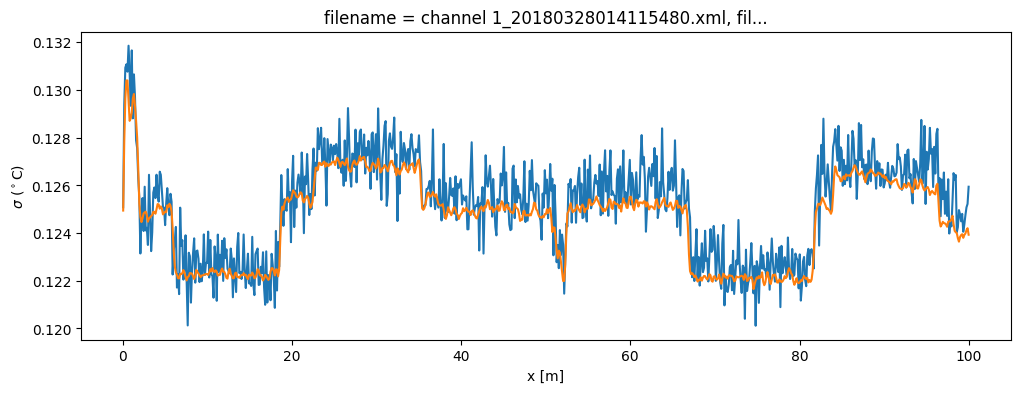

In [18]:
(ds1.tmpw_mc_var**0.5).plot(figsize=(12, 4))
(ds1.tmpw_var_lower**0.5).plot();
plt.ylabel('$\sigma$ ($^\circ$C)');